In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
database_path = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
min_avg_max=calc_temps('2017-08-01', '2017-08-07')
min_avg_max[0]

(72.0, 79.25, 83.0)

In [24]:
df=pd.DataFrame(min_avg_max, columns=['Min Temp', 'Avg Temp', 'Max Temp'])

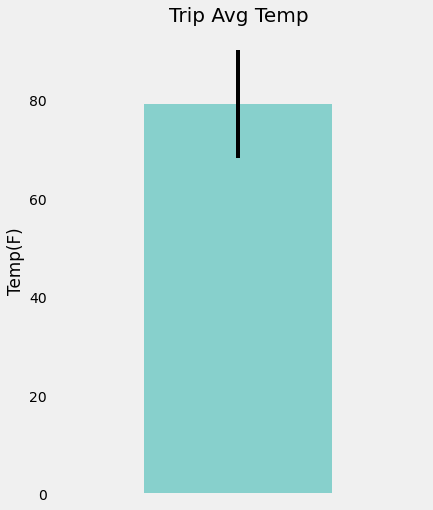

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp = df['Avg Temp']
min_max_temp = df.iloc[0]['Max Temp'] - df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='lightseagreen')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp(F)")
plt.xticks([])
plt.grid()
plt.savefig("Images/temperature.png")
plt.show()

### Daily Rainfall Average

In [37]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
quey_ = session.query(Station.station,Station.name,func.sum(Measurement.prcp),Station.elevation,Station.latitude,Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= '2017-08-01')\
.filter(Measurement.date <= '2017-08-07')\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()

rain_df=pd.DataFrame(quey_,columns=['station','name','rainfall','elevation','latitude','longitude'])
rain_df


,station,name,rainfall,elevation,latitude,longitude
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.36,152.4,21.33310,-157.80250
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.22,7.0,21.52130,-157.83740
2,USC00519281,"WAIHEE 837.5, HI US",0.06,32.9,21.45167,-157.84889
3,USC00519397,"WAIKIKI 717.2, HI US",0.04,3.0,21.27160,-157.81680
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,19.5,21.33556,-157.71139


### Daily Temperature Normals

In [38]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [73]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-08'
start = dt.datetime.strptime(start_date, "%Y-%m-%d")
end = dt.datetime.strptime(end_date, "%Y-%m-%d")

# Use the start and end date to create a range of dates
date_array = (start + dt.timedelta(days=x) for x in range(0, (end-start).days))

# Strip off the year and save a list of strings in the format %m-%d

date_list=[date_object.strftime("%m-%d") for date_object in date_array]
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`
normals=[daily_normals(i)[0] for i in date_list]



In [74]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df=pd.DataFrame(normals,columns=['Min','Avg','Max'],index=date_list)
normals_df

,Min,Avg,Max
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


<Figure size 1440x504 with 0 Axes>

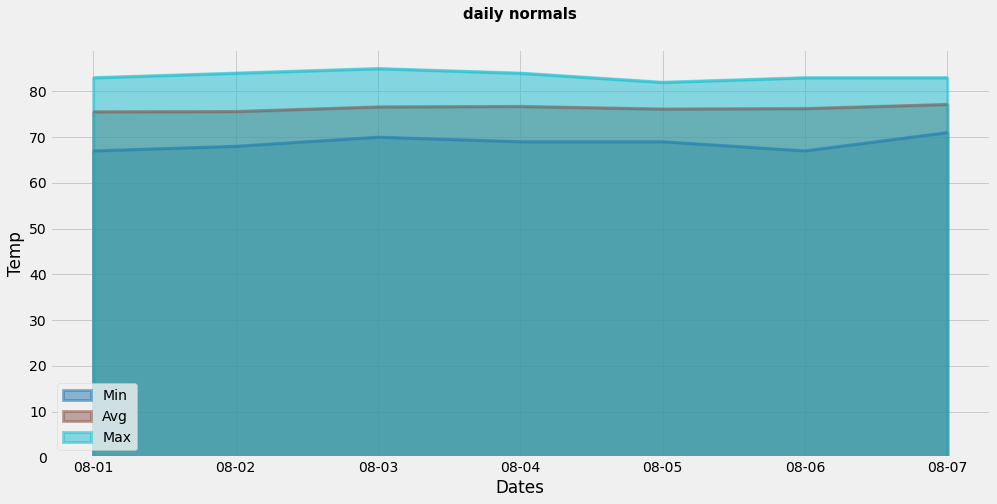

In [78]:
# Plot the daily normals as an area plot with `stacked=False`
plt.figure(figsize=(20,7))
normals_df.plot(kind='area', stacked=False,linewidth=3, colormap="tab10")
plt.title('daily normals',fontsize= 15,pad=30,fontweight="bold")
plt.xlabel('Dates')
plt.ylabel('Temp')
plt.gcf().set_size_inches(15, 7)
plt.savefig('Images/daily_normals.png') 
plt.show()

## Close Session

In [79]:
# Close Session
session.close()